In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use(['dark_background'])
from IPython.display import display, Math

from fem import Fem
from atexpmesh import ArcTanExpMesh
from atplmesh import ArcTanPowerLawMesh
from physics import SymPhysics
from source import TopHatSource, StepSource, GaussianSource
from utils import get_values
from initial_guess import InitialGuess

import numpy as np
import dolfin as d

from symmetron import SymSolver

In [2]:
# options: D = 2 or 3, coupling = 'linear' or 'quadratic'
D = 3
coupling = 'linear'

# source
Ms = 1e3
Rs = 1e-3

# field
mu = 1e0
M = 1e0
lam = .1

physics = SymPhysics( D, coupling, mu, lam, M, Rs, Ms=Ms )

In [3]:
mesh = ArcTanPowerLawMesh( physics )
fem = Fem( mesh )

source = StepSource( fem, physics )

In [4]:
solver = SymSolver( fem, source, physics )
solver.solve()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-01	rel_dphi = 5.0e-01	abs_res = 3.4e+01 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-01	rel_dphi = 3.3e-01	abs_res = 1.0e+01 (tol = 1.0e-10)	rel_res = 3.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.4e-02	rel_dphi = 2.2e-01	abs_res = 3.0e+00 (tol = 1.0e-10)	rel_res = 8.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.8e-02	rel_dphi = 1.4e-01	abs_res = 8.7e-01 (tol = 1.0e-10)	rel_res = 2.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.9e-02	rel_dphi = 8.6e-02	abs_res = 2.6e-01 (tol = 1.0e-10)	rel_res = 7.7e-03 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.4e-02	rel_dphi = 4.1e-02	abs_res = 7.7e-02 (tol = 1.0e-10)	rel_res = 2.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 4.3e-03	rel_dphi = 1.3e-02	abs_res = 2.3e-02 (tol = 1.0e-10)	rel_res =

In [5]:
phi = solver.varPhi

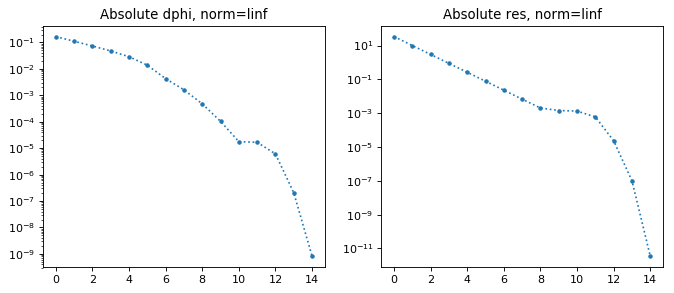

In [6]:
# check the solver has finished: you should see a plateau in these two plots if it has
fig=plt.figure(figsize=(10, 4), dpi=80 )#, facecolor='w', edgecolor='k')

abs_dphi = solver.abs_dphi
abs_res = solver.abs_res

# change in the solution (du) at every iteration
plt.subplot(121)
plt.title('Absolute dphi, norm=%s' % solver.norm_change )
plt.plot( abs_dphi[abs_dphi>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

# weak residual at every iteration
plt.subplot(122)
plt.title('Absolute res, norm=%s' % solver.norm_res )
plt.plot( abs_res[abs_res>0.], ':.' )
#plt.xlim([0,40])
plt.yscale('log')

In [7]:
# extract value of phi at vertices, for plotting
r_values, phi_values = get_values( phi, output_mesh=True )
grad_values = get_values( solver.grad_Phi )

In [8]:
print "Derrick's theorem test #1: these quantities should be equal"
print 'Derrick 1\tDerrick 2\trelative difference'
rel_diff = abs(solver.derrick[0] - solver.derrick[1]) / max( abs(solver.derrick[0]), abs(solver.derrick[1]) )
print '%9.6e\t%9.6e\t%9.3e' % ( solver.derrick[0], solver.derrick[1], rel_diff )
            
print "Derrick's theorem test #2: the first quantity is supposed to be greater than the second"
print 'Derrick 3\t Derrick 4\tDerrick 3 > Derrick 4'
print '%9.6e\t%9.6e\t%s' % ( solver.derrick[2], solver.derrick[3], 
                       solver.derrick[2] >= solver.derrick[3] )

Derrick's theorem test #1: these quantities should be equal
Derrick 1	Derrick 2	relative difference
-2.135420e+06	-2.135491e+06	3.308e-05
Derrick's theorem test #2: the first quantity is supposed to be greater than the second
Derrick 3	 Derrick 4	Derrick 3 > Derrick 4
5.792049e+06	1.606289e+05	True


These are the terms of the equation of motion across the box, as computed by the code

(1e-27, 1e+20)

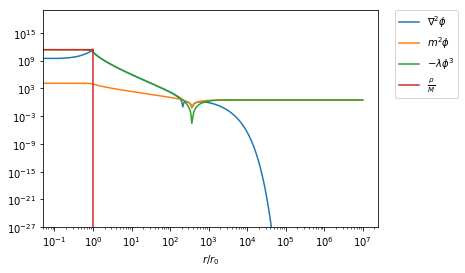

In [14]:
for j in range(1,5):
    term, label = solver.EoM_term( term=j )
    term_values = get_values( term )
    plt.plot( r_values, abs(term_values), '-', label=label )

plt.xlabel(r'$r/r_0$')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([1e-27, 1e20])
#plt.xlim([1e-1, 1e1])

These are the terms of the equation of motion in code units and in terms of any internal auxiliary field - together with the equation residuals

(1e-27, 100000.0)

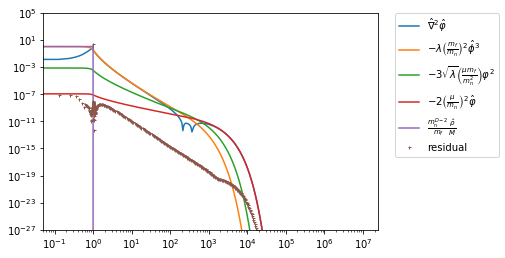

In [10]:
# compare the different terms in the equations
for j in range(1,solver.num_terms + 1):
    term, label = solver.output_term( term=j, output_label=True, units='rescaled' )
    term_values = get_values( term )
    plt.plot( r_values, abs(term_values), '-', label=label )

# plot strong residuals 
F = solver.strong_residual( units='rescaled', norm='none' )
F_values = get_values( F )
plt.plot( r_values, abs(F_values), '+', label='residual', markersize='3' )

plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([1e-27, 1e5])
#plt.xlim([1e-1, 1e1])

In [11]:
# obtain analytic approximations, if available

if solver.initial_guess.rho_eff != (mu*M)**2:
    initial_guess = solver.initial_guess.varPhi
    twopart = solver.old_analytics.varPhi
    old_charge = solver.old_analytics.old_charge

    ig_values = get_values( initial_guess )
    twopart_values = get_values( twopart )
    oldcharge_values = get_values( old_charge )
    
else:
    print("No analytic approximation available at the resonance:")
    display(Math(r"$\rho = (\mu M)^2$" ))
    ig_values = None
    two_part_values = None
    old_charge_values = None

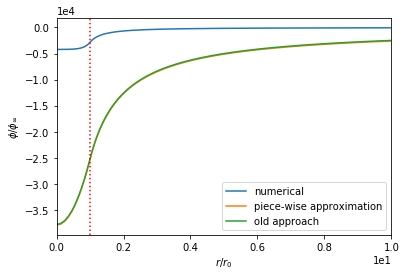

In [12]:
# for ease of visualisation, only plot function up to...
phi_r_stop = mesh.rs * 10.

plt.ylabel( r'$\phi/\phi_{\infty}$' )

plt.plot( r_values, phi_values/solver.physics.Vev, label='numerical' )
try:
    plt.plot( r_values, ig_values/solver.physics.Vev,
             label='piece-wise approximation' )
    plt.plot( r_values, twopart_values/solver.physics.Vev, 
             label='old approach' )
    
except TypeError:
    print("No analytic approximation available at the resonance:")
    display(Math(r"$\rho = (\mu M)^2$" ))
    print("Will not plot analytics")

plt.xlabel(r'$r/r_0$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=mesh.rs, color='red', linestyle=':')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([0., 10.])
plt.legend()


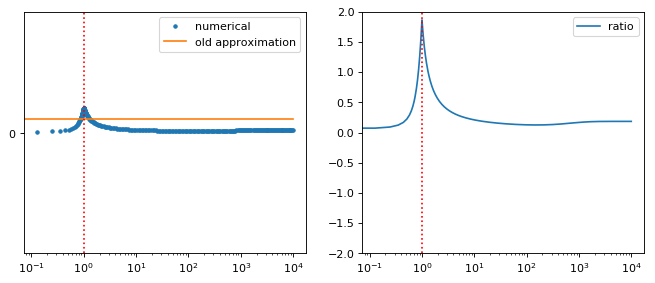

In [13]:
fig=plt.figure(figsize=(10, 4), dpi=80 )

# get numerical screening factor
sf_values = get_values(solver.screening_factor)

# stop at about Compton wavelength
r_stop = np.where( r_values > 1e1/solver.physics.x0 )[0][0]

# comparing different methods of obtaining screening factor
plt.subplot(121)
plt.plot( r_values[:r_stop], sf_values[:r_stop], '.', label='numerical' )
try:
    plt.plot( r_values[:r_stop], oldcharge_values[:r_stop], label='old approximation' )
except NameError:
    print("No analytic approximation available at the resonance:")
    display(Math(r"$\rho = (\mu M)^2$" ))
    print("Will not plot analytics")
    
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=mesh.rs, color='red', linestyle=':')
plt.xscale('log')
plt.yscale('symlog')
plt.ylim(-1.5,1.5)
plt.legend()

plt.subplot(122)
try:
    ratio = sf_values / oldcharge_values
    plt.plot( r_values[:r_stop], ratio[:r_stop], label='ratio' )
except NameError:
    print("No analytic approximation available at the resonance:")
    display(Math(r"$\rho = (\mu M)^2$" ))
    print("Cannot take ratio")
    
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=mesh.rs, color='red', linestyle=':')
plt.xscale('log')
#plt.yscale('symlog')
plt.ylim(-2,2)
plt.legend()